In [17]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon
from sys import path
path.insert(1,'SEIR/')
from SEIR import setup, seir
import datetime

s = setup.Setup(setup_name = 'midSD',
                spatial_setup = setup.CaliforniaSpatialSetup(),
                nsim = 5, 
                ti = datetime.date(2020, 1, 23),
                tf = datetime.date(2020, 4, 1))

seeding_place = 6075
seeding_amount = [3]
s.buildIC(seeding_places = [int(s.spatset.data[s.spatset.data['name'] == seeding_place].id)], 
          seeding_amount = seeding_amount)

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
cases_data = pd.read_csv(url)


counties_shp = gpd.read_file('data/california/california-counties-shp/california-counties.shp')
counties_shp.sort_values('GEOID', inplace=True)

cases_data = cases_data[cases_data['Country/Region'].str.contains('US')]
cases_data = cases_data[cases_data['Province/State'].str.contains('CA')].reset_index(drop=True)

cases_geoid = [0]*len(cases_data)
for idx, row in cases_data.iterrows():
    cases_pos = Point(row['Long'], row['Lat'])
    for key, geom in counties_shp['geometry'].items():
        if (cases_pos.within(geom)):
            cases_geoid[idx] = int(counties_shp['GEOID'][key])

In [6]:
cases_data.index = cases_geoid
cases_data = cases_data.T[4:]
cases_data.index = pd.to_datetime(cases_data.index)

In [8]:
cum_cases_data = cases_data.diff()
cum_cases_data[cum_cases_data < 0] = 0
cum_cases_data = cum_cases_data.cumsum()
cum_cases_data.plot()

In [10]:
filter = np.array((s.nnodes, s.t_span))

In [11]:
cum_cases_data = cum_cases_data.resample('D').backfill()

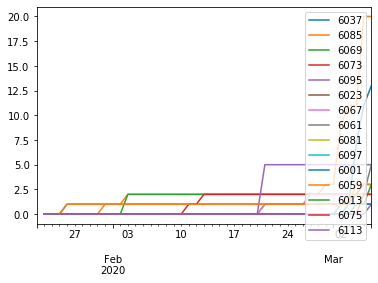

In [12]:
cum_cases_data.plot()

In [13]:
cum_cases_all = pd.DataFrame(0, index = pd.date_range(s.ti, s.tf, freq ='D'), columns = np.arange(s.nnodes))

In [14]:
for col in list(cum_cases_data):
    cum_cases_all[s.spatset.data[s.spatset.data['name'] == col].id] = cum_cases_data[col]
cum_cases_all.fillna(method='ffill', inplace=True)

In [15]:
cum_cases_all.to_numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [18]:
np.savetxt(f'data/california/filter_github.txt', cum_cases_all.to_numpy())